In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 14

import pickle
import tqdm
import colour
from PIL import Image
from scipy.signal import savgol_filter

from zmqRemoteApi import RemoteAPIClient

from IPython.display import clear_output
import time

from utils import normalize, closedLoop
from elman_opt import ElmanPBRNN, save, load, sigmoid

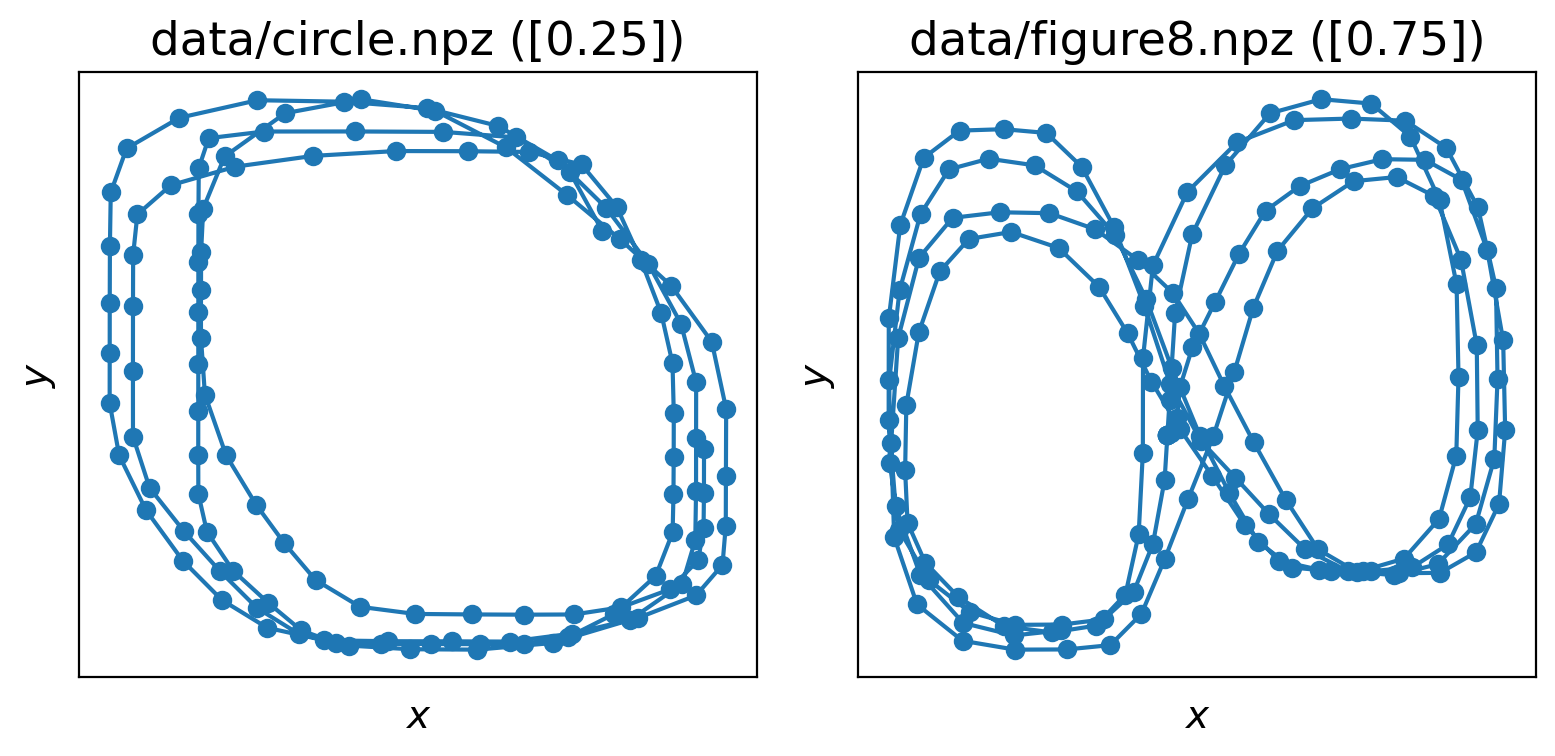

In [65]:
%matplotlib inline

trainingPatterns = ['data/circle.npz', 'data/figure8.npz']#, 'data/square.npz', 'data/triangle.npz']
biasArr = np.array([[.25], [.75]])#, [.5], [.75]])
seqCutOffFactors = 1.5*np.ones(len(trainingPatterns), dtype=np.int16)
#seqCutOffFactors[1] = 2

dsFactor = 4
initialOffset = 200

xScaleFuncArr = []
yScaleFuncArr = []
xArr = []
yArr = []

#biasArr = []

for i in range(len(trainingPatterns)):

    data = np.load(trainingPatterns[i])
    x, xScale = normalize(data["positions"][initialOffset:-int(len(data["positions"])/seqCutOffFactors[i]):dsFactor,0], returnFunc=True)
    y, yScale = normalize(data["positions"][initialOffset:-int(len(data["positions"])/seqCutOffFactors[i]):dsFactor,1], returnFunc=True)

    #x = x[:len(x)//4]
    #y = y[:len(y)//4]

    xArr.append(x)
    yArr.append(y)
    xScaleFuncArr.append(xScale)
    yScaleFuncArr.append(yScale)
    #biasArr.append(np.zeros(len(trainingPatterns)))
    #biasArr[-1][i] = 1
    
fig, ax = plt.subplots(1, len(trainingPatterns), figsize=(len(trainingPatterns)*4, 4))

for i in range(len(ax)):
    ax[i].plot(xArr[i], yArr[i], '-o')
    ax[i].set_title(f'{trainingPatterns[i]} ({biasArr[i]})')
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
inputArr = [np.array(list(zip(xArr[i], yArr[i])))[:-1] for i in range(len(trainingPatterns))]
fig.tight_layout()
#plt.savefig('images/example_patterns.png')
plt.show()

In [66]:
leaderModel = load('models/scalar_2.npz')
followerModel = load('models/scalar_2.npz')

In [25]:
def trackRedBall(img, redTol=30000, normalize=True):
    redPixels = np.where(np.sum((img - np.array([255, 0, 0]))**2, axis=-1) < redTol)
    if len(redPixels) == 0:
        return [np.nan, np.nan], np.zeros_like(img)
    avg = np.mean(redPixels, axis=-1)
    if normalize:
        avg = avg / img.shape[:2]
        
    trackImg = np.zeros_like(img)
    trackImg[redPixels] = [255, 0, 0]
    
    return avg, trackImg

In [116]:
#open connection to CoppeliaSim, must be running
client = RemoteAPIClient()
sim = client.getObject('sim')

#open scene in the simulator:
import os 
dir_path = os.getcwd()

sim.loadScene(dir_path+'/torobo.ttt')

#we will use synchronous mode, client.step() will perform one simulation step
#otherwise the simulator runs freely, e.g. time can pass between mutliple simulator calls:
#e.g. sending commands to multiple joints may happen at different times
client.setStepping(True)

In [28]:
#Read object ids from scene
hands = [sim.getObject('./tip_left'), sim.getObject('./tip_right')]
rightShoulderJoints = [[sim.getObject(f'/world_visual[{i}]/right_arm_joint_1'), sim.getObject(f'/world_visual[{i}]/right_arm_joint_2')] for i in range(2)]

visionSensors = [sim.getObject('/world_visual[0]/kinect_rgb'), sim.getObject('/world_visual[1]/kinect_rgb')]
trackerSphere = sim.getObject('/world_visual[1]/tracker_ball')

In [7]:
objects = sim.getObjectsInTree(sim.getObject('/world_visual[1]'))
for o in objects:
    print(sim.getObjectAlias(o))

world_visual
joint_base
base_respondable
torso_head_root
base_visual
torso_head_link_0_respondable
torso_head_joint_1
torso_head_link_0_visual
torso_head_link_1_respondable
torso_head_joint_2
torso_head_link_1_visual
torso_head_link_2_respondable
torso_head_joint_3
torso_head_link_2_visual
left_arm_root
right_arm_root
torso_head_link_3_respondable
left_arm_link_0_respondable
right_arm_link_0_respondable
torso_head_joint_4
torso_head_link_3_visual
left_arm_joint_1
left_arm_link_0_visual
right_arm_joint_1
right_arm_link_0_visual
torso_head_link_4_respondable
left_arm_link_1_respondable
right_arm_link_1_respondable
torso_head_camera_joint
torso_head_link_4_visual
left_arm_joint_2
left_arm_link_1_visual
right_arm_joint_2
right_arm_link_1_visual
torso_head_camera_link_respondable
left_arm_link_2_respondable
right_arm_link_2_respondable
torso_head_camera_link_visual
kinect_depth
kinect_rgb
camera_view_direction
left_arm_joint_3
left_arm_link_2_visual
right_arm_joint_3
right_arm_link_2_visual

In [151]:
sim.startSimulation()
nSteps = 400
imgArr = [[], []]
ballPosArr = []
trackImgArr = []
jointPosArr = []
scaledJointPosArr = []

followerJointPosArr = []
followerScaledJointPosArr = []

biasSeqArr = [0, 1]
biasStepSmoothness = 10.
testBiasArr = np.zeros((nSteps, len(biasArr[0])))
identifiedBiasArr = np.zeros((nSteps, len(biasArr[0])))
predictionStepsPerBias = nSteps // len(biasSeqArr)

for i in range(len(biasSeqArr)):
    testBiasArr[i*predictionStepsPerBias:(i+1)*predictionStepsPerBias,:] = np.repeat([biasArr[biasSeqArr[i]]], predictionStepsPerBias, axis=0)

if biasStepSmoothness > 0:
    smoothingWindow = int(1+2*np.ceil(biasStepSmoothness*3))
    for i in range(len(testBiasArr[0])):
        testBiasArr[:,i] = savgol_filter(testBiasArr[:,i], 1+6*int(biasStepSmoothness), 1)

imitationTrackingWindowSize = 50

try:
    # The wrists are bent to start, so let's straighten them out
    sim.setJointTargetPosition(sim.getObject('/world_visual[0]/right_arm_joint_6'), 0)
    sim.setJointTargetPosition(sim.getObject('/world_visual[0]/left_arm_joint_6'), 0)
    sim.setJointTargetPosition(sim.getObject('/world_visual[0]/right_arm_joint_1'), 0)
    sim.setJointTargetPosition(sim.getObject('/world_visual[0]/right_arm_joint_2'), 0)

    # Set the ball attached to the second robots hand to be red, so the
    # first one can track it
    #sim.setShapeColor(trackerSphere, None, sim.colorcomponent_ambient_diffuse, [1, 0, 0])

    handPos = np.zeros((2,nSteps,3))
    tArr = np.zeros(nSteps)

    jointPosArr.append(np.array(inputArr[0][0]))
    followerJointPosArr.append(np.array(inputArr[0][0]))

    for i in tqdm.tqdm(range(nSteps)):

        jointPos = leaderModel.predict(jointPosArr[-1], testBiasArr[i], 1, True)[1]
        jointPosArr.append(jointPos)
        scaledJointPosArr.append([xScale(jointPos[0])-.3, yScale(jointPos[1])])
        
        sim.setJointTargetPosition(rightShoulderJoints[1][1], scaledJointPosArr[-1][0])
        sim.setJointTargetPosition(rightShoulderJoints[1][0], scaledJointPosArr[-1][1])

        # Read the positions of the hands
        for j in range(2):
            handPos[j,i] = sim.getObjectPosition(hands[j], sim.handle_world)

        # See if the other robot can identify the bias vector
        if len(ballPosArr) > 40:#imitationTrackingWindowSize:
            trackingData = np.array(ballPosArr[-imitationTrackingWindowSize:])
            # We have to normalize based on where we've seen the ball so far
            trackingData[:,0] = normalize(trackingData[:,0])
            trackingData[:,1] = normalize(trackingData[:,1])
            identifiedBiasArr[i] = followerModel.recognize(trackingData)
            
            if np.isnan(followerJointPosArr[-1][0]):
                raise Exception('NaN')

            jointPos = followerModel.predict(followerJointPosArr[-1], identifiedBiasArr[i], 1, True)[1]
            followerJointPosArr.append(jointPos)
            followerScaledJointPosArr.append([xScale(jointPos[0])-.3, yScale(jointPos[1])])
            #print(followerScaledJointPosArr[-1])
            
            sim.setJointTargetPosition(rightShoulderJoints[0][1], xScale(jointPos[0]))
            sim.setJointTargetPosition(rightShoulderJoints[0][0], yScale(jointPos[1]))

        #next time step
        client.step()
        tArr[i] = sim.getSimulationTime()
        
        for j in range(len(visionSensors)):
            img, imgSize = sim.getVisionSensorImg(visionSensors[j])
            img = np.reshape(np.frombuffer(img, np.uint8), (*imgSize[::-1], 3))[::-1]
            imgArr[j].append(img)
            
        # Track the ball in the second robot's hand
        pos, trackImg = trackRedBall(imgArr[0][-1], normalize=False)
        if np.sum(trackImg) == 0:
            ballPosArr.append(ballPosArr[-1])
        else:
            ballPosArr.append(pos)
        trackImgArr.append(trackImg)

finally:
    sim.stopSimulation()

100%|███████████████████████████████| 400/400 [07:36<00:00,  1.14s/it]


In [138]:
followerModel.predict(followerJointPosArr[0], identifiedBiasArr[0], 1, False)[1]

array([0.8319754 , 0.37822666])

In [65]:
with open('test_arr.pick', 'wb') as file:
    pickle.dump(trackingData, file)

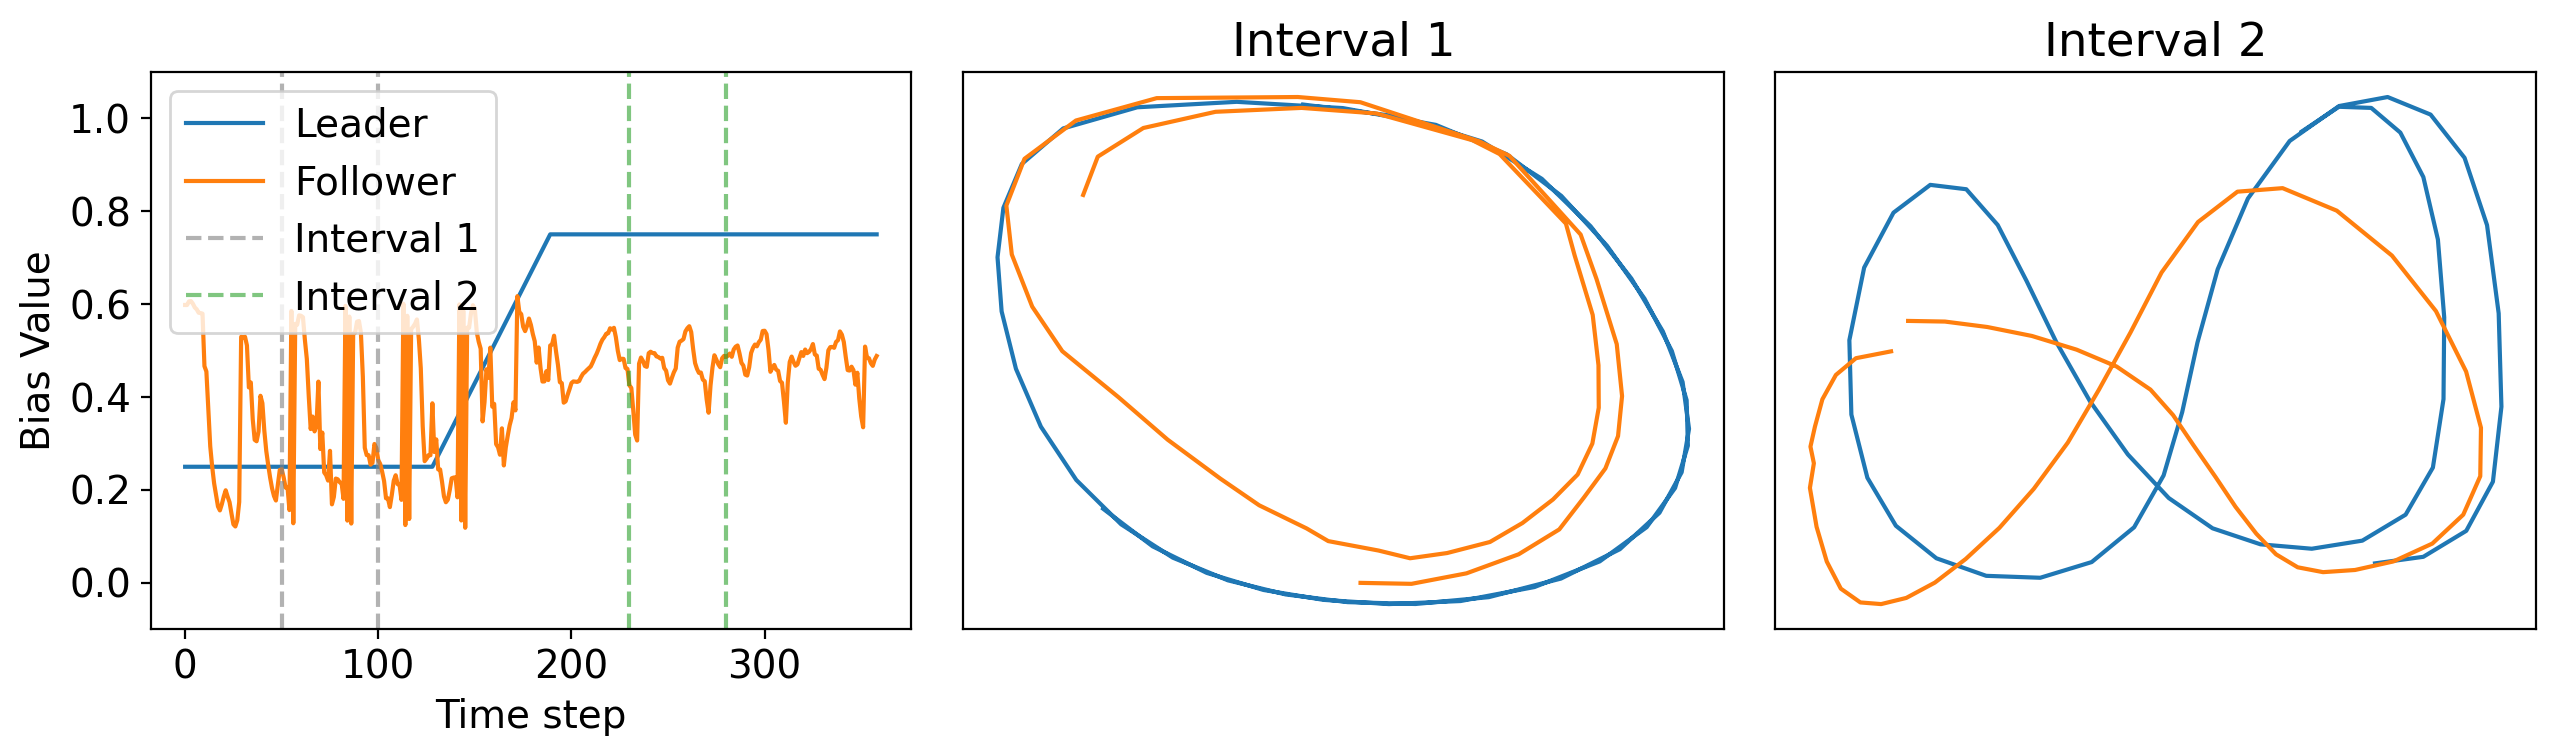

In [163]:
%matplotlib inline

trackingData = np.array(ballPosArr[-60:])
# We have to normalize based on where we've seen the ball so far
trackingData[:,0] = normalize(trackingData[:,0])
trackingData[:,1] = normalize(trackingData[:,1])
# genBiasArr = []
# for i in tqdm.tqdm(range(50)):
#     identifiedBias = followerModel.recognize(trackingData)
#     genBiasArr.append(identifiedBias)
    
#genBiasArr = np.array(genBiasArr)

#plt.plot(genBiasArr[:,0])
#plt.show()
#plt.plot(trackingData[:,0], trackingData[:,1])
#plt.show()

# plt.plot(trackingData[:,0], trackingData[:,1])
# plt.show()
# plt.hist(np.array(genBiasArr)[:,0])
# plt.show()
# print(identifiedBias)

fig, ax = plt.subplots(1, 3, figsize=(13,4))

interval = [[50, 100], [230, 280]]

for j in range(len(testBiasArr[0])):
    ax[0].plot(testBiasArr[41:,j], label='Leader')
    ax[0].plot(identifiedBiasArr[41:,j], label='Follower')

ax[0].axvline(interval[0][0], linestyle='--', c='gray', alpha=.6, label='Interval 1')
ax[0].axvline(interval[0][1], linestyle='--', c='gray', alpha=.6)

ax[0].axvline(interval[1][0], linestyle='--', c='tab:green', alpha=.6, label='Interval 2')
ax[0].axvline(interval[1][1], linestyle='--', c='tab:green', alpha=.6)

ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Bias Value')
ax[0].legend()
ax[0].set_ylim([-.1, 1.1])

for i in range(2):
    ax[1+i].set_title(f'Interval {1+i}')
    ax[1+i].plot(np.array(jointPosArr)[interval[i][0]:interval[i][1],0], np.array(jointPosArr)[interval[i][0]:interval[i][1],1], label='Leader')
    ax[1+i].plot(np.array(followerJointPosArr)[interval[i][0]:interval[i][1],0], np.array(followerJointPosArr)[interval[i][0]:interval[i][1],1], label='Follower')
    ax[1+i].set_xticks([])
    ax[1+i].set_yticks([])
    
fig.tight_layout()
#plt.savefig('images/paired_exp_results.pdf')
plt.show()

KeyboardInterrupt: 

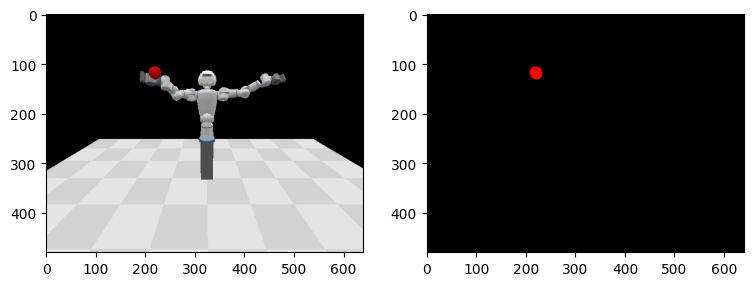

In [201]:
for i in range(nSteps):

    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(9,4))

    ax[0].imshow(imgArr[0][i])

    avg, trackImg = trackRedBall(imgArr[0][i])
    ax[1].imshow(trackImgArr[i])

    fig.tight_layout()
    plt.show()
    
    time.sleep(.5)

KeyboardInterrupt: 

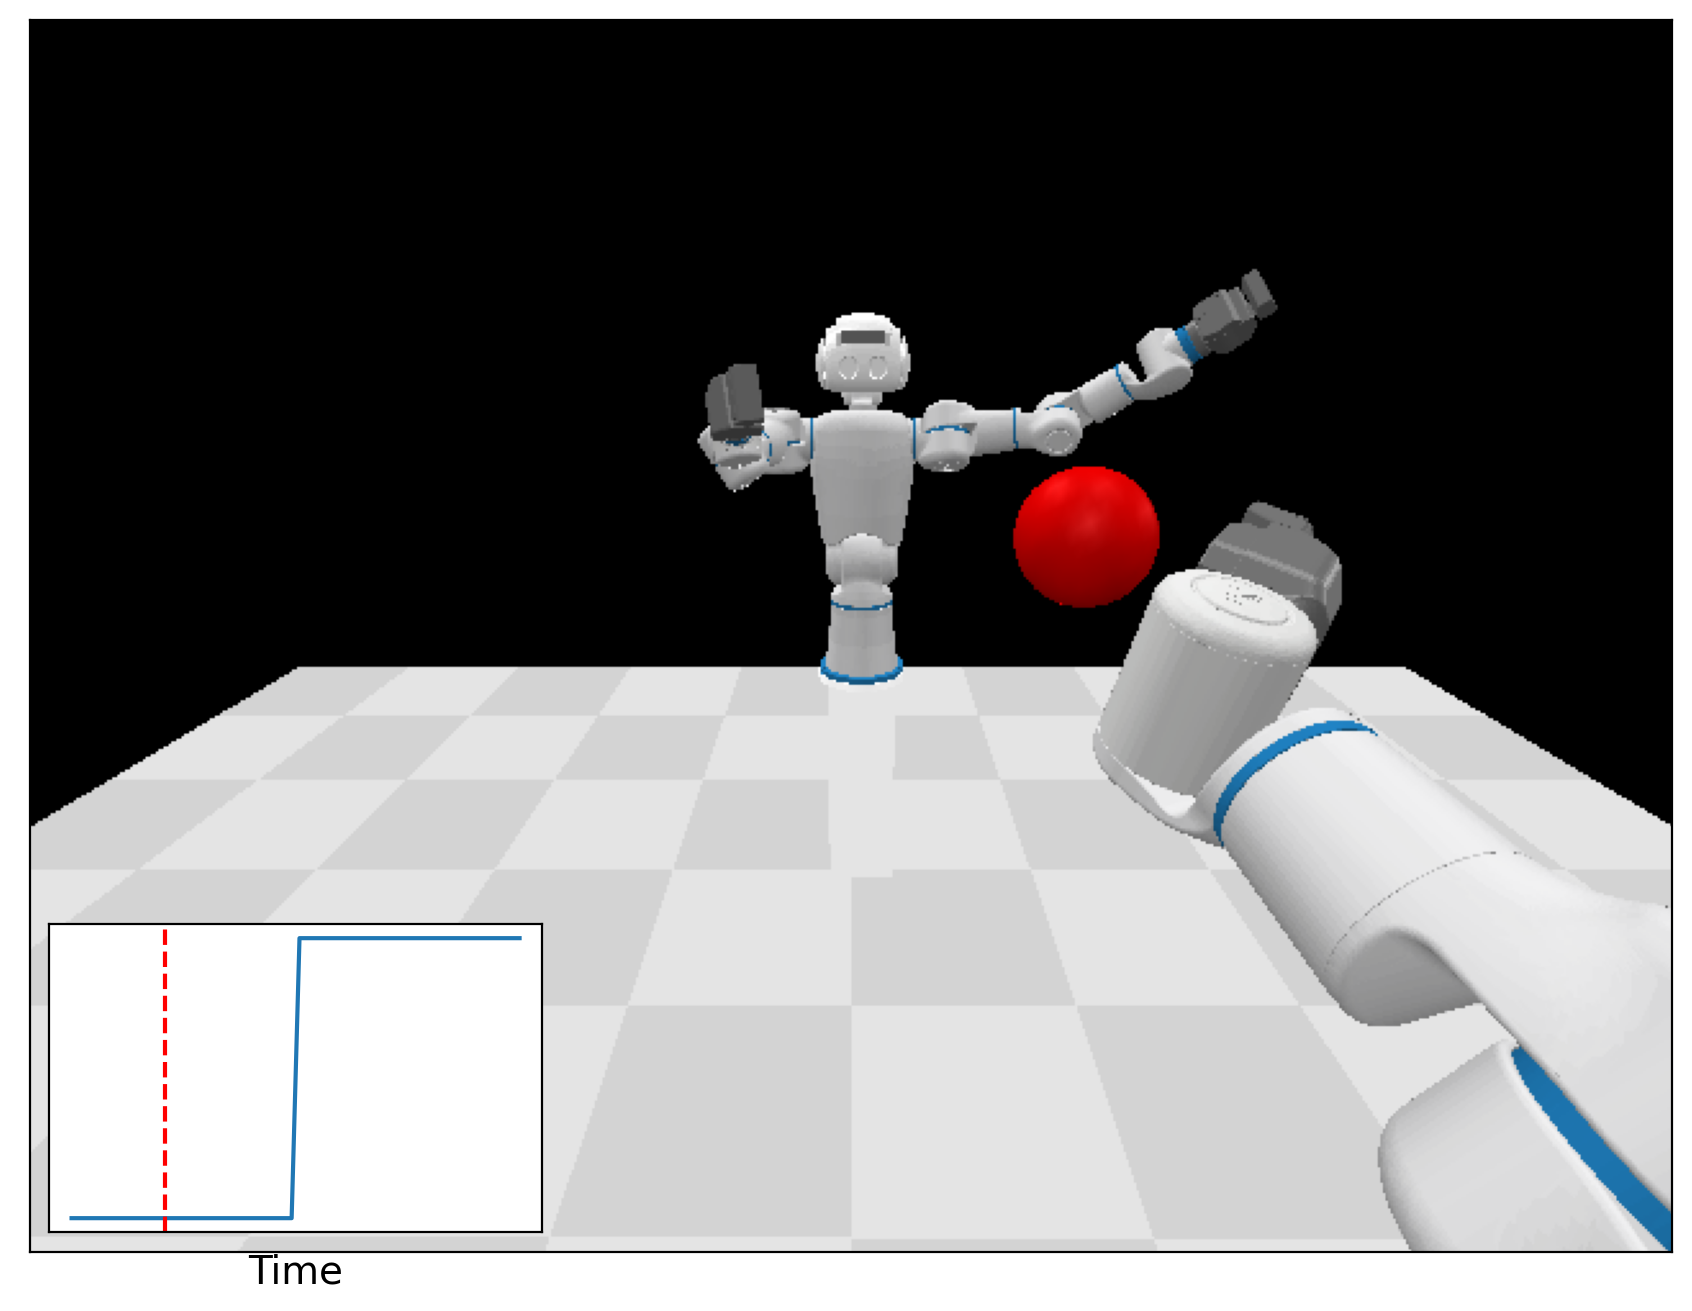

In [20]:
%matplotlib inline
pilImgArr = []

for i in range(20, len(imgArr[0])):
    
    fig, ax = plt.subplots(1, 1, figsize=(12.8/1.2, 9.6/1.2))
    ax.imshow(imgArr[1][i])
    ax.set_xticks([])
    ax.set_yticks([])
    
    inset = inset_axes(ax, width="30%", height="25%", loc=3)
    for j in range(len(testBiasArr[0])):
        inset.plot(testBiasArr[:,j])
    inset.set_xticks([])
    inset.set_yticks([])
    inset.set_xlabel('Time')
    inset.axvline(i, linestyle='--', c='r')
    
    #fig.tight_layout()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    pilImgArr.append(Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb()))

    plt.close()
    
pilImgArr[0].save(f'images/basic_robot_example.gif', save_all=True, append_images=pilImgArr[1:], duration=10, loop=0)

In [154]:
pilImgArr = []
posArr = np.array(ballPosArr)
%matplotlib inline

for i in tqdm.tqdm(range(20, len(imgArr[0]))):
    
    fig, ax = plt.subplots(1, 1, figsize=(12.8 / 1.2, 9.6 / 1.2))
    ax.imshow(imgArr[0][i])
    ax.set_xticks([])
    ax.set_yticks([])
    
    inset = inset_axes(ax, width="30%", height="25%", loc=3)
    for j in range(len(testBiasArr[0])):
        inset.plot(testBiasArr[:,j], label='Leader')
        inset.plot(identifiedBiasArr[:,j], label='Follower')

    inset.axvline(i, linestyle='--', c='r')
    inset.set_ylabel('Bias')
    inset.set_title('Bias States')
    inset.set_ylim([-.1, 1.1])
    
    inset2 = inset_axes(ax, width="30%", height="25%", loc=4)
    inset2.imshow(trackImgArr[i])
    inset2.plot(posArr[20:i,1], posArr[20:i,0], alpha=.4)
    #inset2.set_xticks([])
    #inset2.set_yticks([])

    #fig.tight_layout()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    pilImgArr.append(Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb()))

    plt.close()
    
pilImgArr[0].save(f'images/robot_imitation_4.gif', save_all=True, append_images=pilImgArr[1:], duration=10, loop=0)

100%|███████████████████████████████| 380/380 [02:21<00:00,  2.68it/s]


In [165]:
pilImgArr[250].save(f'images/robot_imitation_4_still.png')

In [18]:
plt.plot(np.array(ballPosArr)[:,0], np.array(ballPosArr)[:,1])
plt.show()

In [108]:
%matplotlib qt

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1, projection='3d')

#ax.scatter(handPos[0,:,0], handPos[0,:,1], handPos[0,:,2], label='Left')
ax.scatter(handPos[1,:,0], handPos[1,:,1], handPos[1,:,2], label='Right')
ax.set_title('Hand Positions')
#ax.set_xlabel('Time [s]')?
ax.legend()

# ax2 = fig.add_subplot(1, 2, 2)

# ax2.plot(predictArr[:,0], predictArr[:,1])
# ax2.set_xlabel('Joint 1 angle')
# ax2.set_ylabel('Joint 2 angle')

fig.tight_layout()
plt.show()

In [26]:
sim.stopSimulation()

ZMQError: Operation cannot be accomplished in current state